## Topological Data Quality notebook

Here we review some examples from the article ``A topological Approach to Measuring Training Data Quality'' arXiv:2306.02411


In [1]:
import os
import numpy as np
import scipy.spatial.distance as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import gudhi

import IBloFunMatch_inter as ibfm

_tol = 1e-10

# output_dir = "output\\" # (Windows)
output_dir = "output/" # (Linux)

### Define a function for calling C++ program compiled from IBloFunMatch.cc

In [2]:
def get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset):
    IBloFunMatch_output = [] # Store all output here 
    # Buffer files to write subsets and classes for communicating with C++ program 
    # f_ind_sampl = output_dir + "\\indices_sample.out"
    # f_dist_X = output_dir + "\\dist_X.out"
    # f_dist_S = output_dir + "\\dist_S.out"
    for idx_class in range(NUM_class):
        for idx_subset in range(NUM_subset):
            print(f"Class: {idx_class:5d}, Subset:{idx_subset:5d}")
            print( "============================")
            output_data = {}
            # Subset and dataset points pertaining to class 
            subset = S_list[idx_subset]
            y_subset = yS_list[idx_subset]
            S = subset[y_subset==idx_class]
            X = data[y==idx_class]
            output_data["S"]=S
            output_data["X"]=X
            # Indices of points from S within X and save
            idS = [np.argmax(np.sum(abs(X - pt), axis=1) < _tol) for pt in S]
            output_data["idS"]=idS
            # np.savetxt(f_ind_sampl, idS, fmt="%d", newline="\n")
            # Compute distance matrices and save
            Dist_X = dist.squareform(dist.pdist(X))
            Dist_S = dist.squareform(dist.pdist(S))
            output_data_ibfm = ibfm.get_IBloFunMatch_subset(Dist_S, Dist_X, idS, output_dir)
            for key in output_data_ibfm.keys():
                output_data[key] = output_data_ibfm[key]
            # end for
            IBloFunMatch_output.append(output_data)
            print("DONE--------------------------------")
        # subset range 
    # class range  
    return IBloFunMatch_output
# def get_IBloFunMatch_output_range

### Example 1

In [3]:
# Load data and labels
data = np.genfromtxt("data_first/dataset.txt")
y = np.genfromtxt("data_first/labels.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_first/subset1.txt")
S2 = np.genfromtxt("data_first/subset2.txt")
S3 = np.genfromtxt("data_first/subset3.txt")
# Load their labels 
yS1 = np.genfromtxt("data_first/labels_subset1.txt")
yS2 = np.genfromtxt("data_first/labels_subset2.txt")
yS3 = np.genfromtxt("data_first/labels_subset3.txt")

In [4]:
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 3
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2, S3]
yS_list = [yS1, yS2, yS3]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset)

Class:     0, Subset:    0
sample_indices (5): 23, 49, 0, 28, 11, 
sorted sample indices
Correctly checked inequality on dist_S and dist_X
Sample indices (sorted)
0, 11, 23, 28, 49, 
Welcome to PerMoVEC!
The subcomplex contains 13 simplices  after collapse. 
   and has dimension 2 
The subcomplex contains 468 simplices  after collapse. 
   and has dimension 2 
Cycle columns image 1: 
Checking zero columns:

1 PM_matrix:

PM_matrix end
Ready to compute block functions
Length X_barcode[1]: 3
Filling red_pm_matrix
Filled, printing: 
3 : 
Now going to reduce
Reduced
Image intervals:
idx_S: 0 (not matched)

DONE--------------------------------
Class:     0, Subset:    1
sample_indices (5): 33, 25, 29, 43, 10, 
sorted sample indices
Correctly checked inequality on dist_S and dist_X
Sample indices (sorted)
10, 25, 29, 33, 43, 
Welcome to PerMoVEC!
The subcomplex contains 9 simplices  after collapse. 
   and has dimension 1 
The subcomplex contains 468 simplices  after collapse. 
   and has di

usetex mode requires TeX.


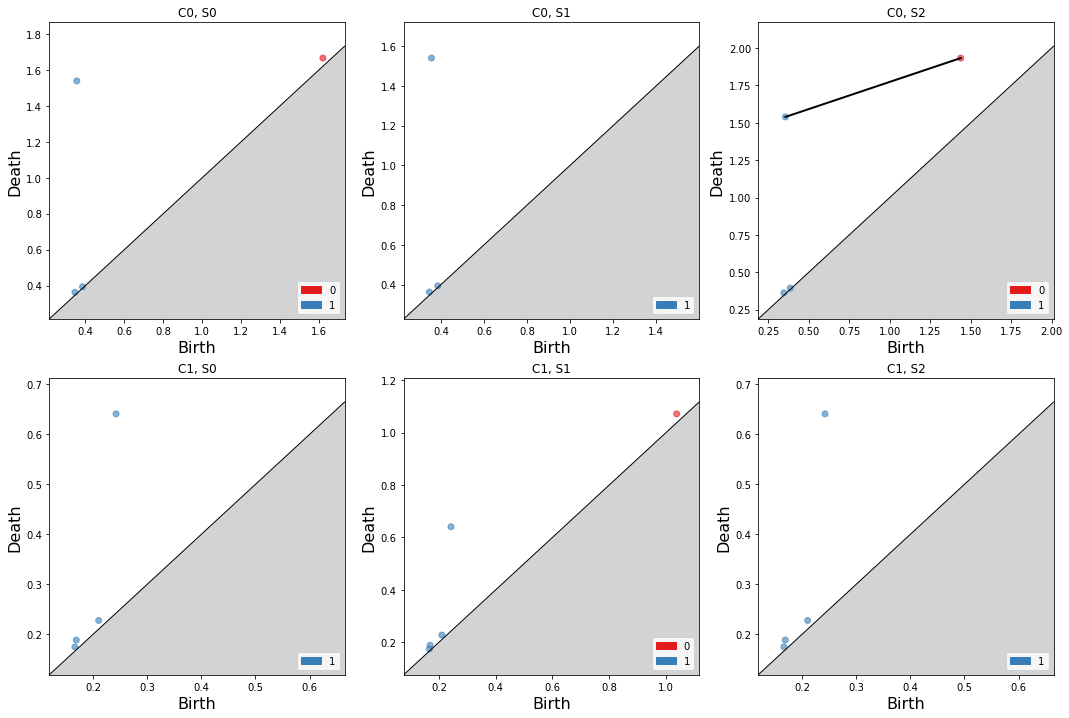

In [5]:
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("plots/TDQ/first_example_matchings.png")

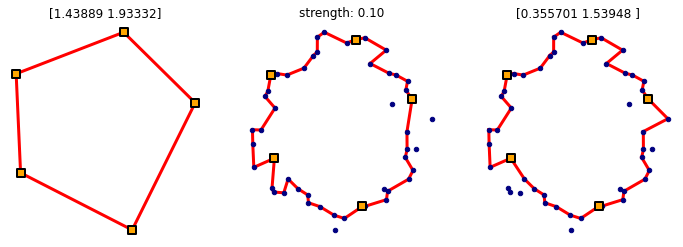

In [6]:
# Plot Point Clouds to visualize matchings
# Only relevant case is C0, S2
# Get relevant data
curr_output = IBloFunMatch_output[class_sub_idx[0][2]]
X = curr_output["X"]
S = curr_output["S"]
induced_matching = curr_output["induced_matching"]
matching_strengths = curr_output["matching_strengths"]
X_reps = curr_output["X_reps"]
X_barcode = curr_output["X_barcode"]
S_reps = curr_output["S_reps"]
S_barcode = curr_output["S_barcode"]
S_reps_im = curr_output["S_reps_im"]
# Plot point clouds and matched representatives
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
# Titles of plots 
ax[0].set_title(f"{S_barcode[0]}")
ax[1].set_title(f"strength: {matching_strengths[0]:.2f}")
ax[2].set_title(f"{X_barcode[induced_matching[0]]}")
#Plot cycle representatives of matching
Srep = S_reps[0].copy()
while len(Srep)>0:
    edge_points = X[[Srep.pop(), Srep.pop()]]
    ax[0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
Srep_im = S_reps_im[0].copy()
while len(Srep_im)>0:
    edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
    ax[1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
Xrep = X_reps[induced_matching[0]].copy()
while len(Xrep)>0:
    edge_points = X[[Xrep.pop(), Xrep.pop()]]
    ax[2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
# Scatter Points
for idx, ax_it in enumerate(ax):
    if idx>0:
        ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=20)
    ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=50)
    ax_it.set_xticks([])
    ax_it.set_yticks([])
    ax_it.axis("off")
# end plotting cycles 
plt.savefig("plots/TDQ/first_exp_matched_reps.png")

### Example 2

In [7]:
# Load data and labels
data = np.genfromtxt("data_second/dataset2.txt")
y = np.genfromtxt("data_second/dataset2_label.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_second/data2_subset1.txt")
S2 = np.genfromtxt("data_second/data2_subset2.txt")
# Load their labels 
yS1 = np.genfromtxt("data_second/data2_subset1_labels.txt")
yS2 = np.genfromtxt("data_second/data2_subset2_labels.txt")

In [8]:
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 2
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2]
yS_list = [yS1, yS2]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset)

Class:     0, Subset:    0
sample_indices (50): 26, 65, 40, 52, 31, 45, 13, 74, 78, 55, 82, 54, 42, 89, 50, 27, 7, 0, 36, 1, 80, 47, 75, 19, 29, 68, 57, 21, 15, 73, 86, 12, 67, 88, 59, 64, 24, 11, 62, 72, 69, 10, 44, 58, 61, 56, 34, 25, 4, 85, 
sorted sample indices
Correctly checked inequality on dist_S and dist_X
Sample indices (sorted)
0, 1, 4, 7, 10, 11, 12, 13, 15, 19, 21, 24, 25, 26, 27, 29, 31, 34, 36, 40, 42, 44, 45, 47, 50, 52, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 67, 68, 69, 72, 73, 74, 75, 78, 80, 82, 85, 86, 88, 89, 
Welcome to PerMoVEC!
The subcomplex contains 249 simplices  after collapse. 
   and has dimension 2 
The subcomplex contains 555 simplices  after collapse. 
   and has dimension 2 
Cycle columns image 1: 
Checking zero columns:

1 PM_matrix:
0, 
6, 
9, 10, 11, 

10, 
11, 
PM_matrix end
Ready to compute block functions
Length X_barcode[1]: 12
Filling red_pm_matrix
Filled, printing: 
12 : 0 
13 : 6 
14 : 11 
15 : 10 
16 : 9 10 11 
17 : 
Now going to reduce
Red

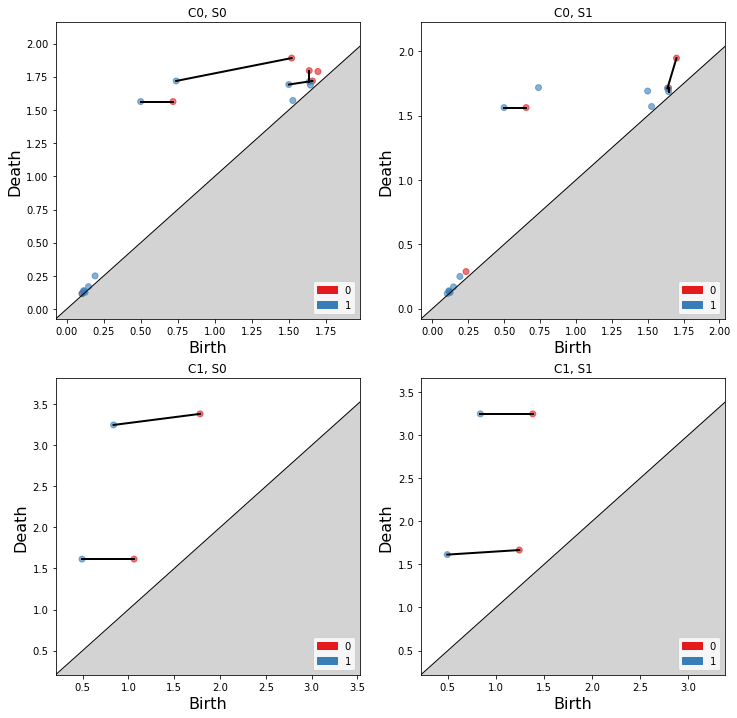

In [9]:
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("plots/TDQ/second_example_matchings.png")

In [10]:
%%capture
cm_reds = mpl.colormaps["Reds"]
cm_blues = mpl.colormaps["Blues"]
# Plot Point Clouds to visualize matchings
# Range over classes and subsets 
# Get relevant data
class_colors=["red", "navy"]
class_cm=[cm_reds, cm_blues]
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class][idx_subset]]
        X = curr_output["X"]
        S = curr_output["S"]
        induced_matching = curr_output["induced_matching"]
        matching_strengths = curr_output["matching_strengths"]
        # Count number of nontrivial matchings 
        num_matchings = len([idx for idx in induced_matching if idx>-1])
        X_reps = curr_output["X_reps"]
        X_barcode = curr_output["X_barcode"]
        S_reps = curr_output["S_reps"]
        S_barcode = curr_output["S_barcode"]
        S_reps_im = curr_output["S_reps_im"]
        # Plot point clouds and matched representatives
        fig, ax = plt.subplots(nrows=num_matchings, ncols=4, figsize=(25, 4*num_matchings))
        #Plot cycle representatives of matching
        
        row_count = 0
        
        max_bar_X_length = np.max(X_barcode[:,1]-X_barcode[:,0])
        for idx_rep, idx_match in enumerate(induced_matching):
            if idx_match <0:
                continue
            # Colored square with strength quantity printed
            ax[row_count, 3].text(0.2, 0.35, f"{matching_strengths[idx_rep]:.2f}", fontsize=100, zorder=1)
            ax[row_count, 3].set_facecolor(class_cm[idx_class](matching_strengths[idx_rep]/X_barcode[idx_match][1]))
            Srep = S_reps[idx_rep].copy()
            while len(Srep)>0:
                edge_points = X[[Srep.pop(), Srep.pop()]]
                ax[row_count, 0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Srep_im = S_reps_im[idx_rep].copy()
            while len(Srep_im)>0:
                edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
                ax[row_count, 1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Xrep = X_reps[idx_match].copy()
            while len(Xrep)>0:
                edge_points = X[[Xrep.pop(), Xrep.pop()]]
                ax[row_count, 2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            # Scatter Points
            for idx, ax_it in enumerate(ax[row_count]):
                if (idx>0) and (idx<3):
                    ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=10)
                if idx < 3:
                    ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=30)
                ax_it.set_xticks([])
                ax_it.set_yticks([])
            # end plotting cycles
            row_count+=1
        # end going over different matchings 
        fig.tight_layout()
        fig.patch.set_facecolor(class_colors[idx_class])
        plt.savefig(f"plots/TDQ/second_reps_{idx_class}_{idx_subset}.png")
    # subset range 
# class range

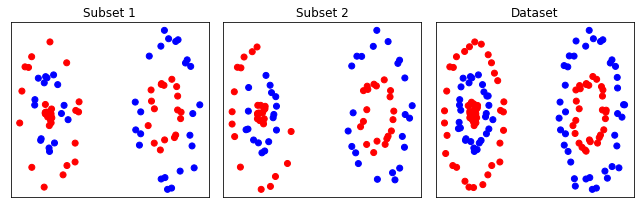

In [11]:
colors=["red", "blue"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
# First subset
S1 = S_list[0]
yS1 = yS_list[0]
for idx, (S, yS) in enumerate(zip(S_list, yS_list)):
    yS = yS.astype("int")
    colorlist = [colors[label] for label in yS]
    ax[idx].scatter(S[:,0], S[:,1], color=colorlist)
    ax[idx].set_title(f"Subset {idx+1}")

# Total point cloud
y = y.astype("int")
colorlist = [colors[label] for label in y]
ax[2].scatter(data[:,0], data[:,1], color=colorlist)
ax[2].set_title("Dataset")
for ax_it in ax:
    ax_it.set_xticks([])
    ax_it.set_yticks([])
fig.tight_layout()
plt.savefig("plots/TDQ/second_points_and_samples.png")

In [12]:
IBloFunMatch_output[0]["pm_matrix"]

[[0], [6], [11], [10], [9, 10, 11], []]

In [13]:
IBloFunMatch_output[0]["S_barcode"]

array([[0.104161, 0.116924],
       [0.71817 , 1.56276 ],
       [1.51872 , 1.89042 ],
       [1.63747 , 1.79588 ],
       [1.65944 , 1.71795 ],
       [1.69628 , 1.78933 ]])

In [14]:
IBloFunMatch_output[0]["X_barcode"]

array([[0.104161, 0.116924],
       [0.124537, 0.125989],
       [0.117571, 0.134394],
       [0.114988, 0.139022],
       [0.147851, 0.169133],
       [0.192112, 0.250175],
       [0.499519, 1.56276 ],
       [1.52703 , 1.57101 ],
       [1.64577 , 1.68684 ],
       [1.49978 , 1.6911  ],
       [1.63747 , 1.71244 ],
       [0.739474, 1.71795 ]])

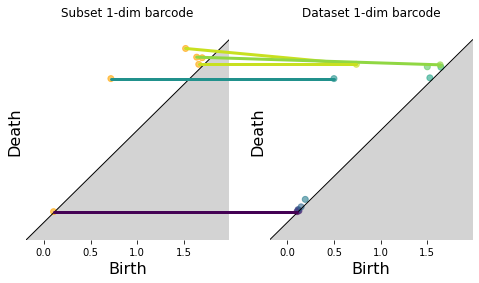

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
S_barcode = IBloFunMatch_output[0]["S_barcode"]
X_barcode = IBloFunMatch_output[0]["X_barcode"]
max_val = max(np.max(S_barcode),np.max(X_barcode))
S_pers = [(0, tuple(bar)) for bar in S_barcode]+[(1,[0,max_val])]
# viridis_cm = mpl.colormaps["viridis"].resampled(X_barcode.shape[0])
viridis_cm = mpl.colormaps["viridis"]
X_pers = [(idx, tuple(bar)) for idx, bar in enumerate(X_barcode)]+[(X_barcode.shape[0],[0,max_val])]
gudhi.plot_persistence_diagram(persistence=S_pers, axes=ax[0], colormap=["orange", "white"])
viridis_colors = [viridis_cm(idx/X_barcode.shape[0]) for idx in range(X_barcode.shape[0])] + ["white"]
gudhi.plot_persistence_diagram(persistence=X_pers, axes=ax[1], colormap=viridis_colors)
ax[0].set_title("Subset 1-dim barcode")
ax[1].set_title("Dataset 1-dim barcode")
## Plot Block Function
block_function = []
for col in IBloFunMatch_output[0]["pm_matrix"]:
    if len(col)==0:
        block_function.append(-1)
    else:
        block_function.append(col[-1])
    # end if else 
# end for 
for idx, idx_match in enumerate(block_function):
    pt_S = S_barcode[idx]
    if idx_match==-1:
        continue
    pt_X = X_barcode[idx_match]
    con = mpl.patches.ConnectionPatch(
        xyA=pt_S, coordsA=ax[0].transData, 
        xyB=pt_X, coordsB=ax[1].transData,
        arrowstyle="-", connectionstyle='arc',
        color=viridis_colors[idx_match], linewidth=3, zorder=1
    )
    fig.add_artist(con)
# end for
    
### Set up plotting options 
for ax_it in ax:
    ax_it.set_frame_on(False)
    ax_it.set_yticks([])
    ax_it.get_legend().set_visible(False)
# end for 
plt.savefig("plots/TDQ/Block_function_S0_ex2.png")

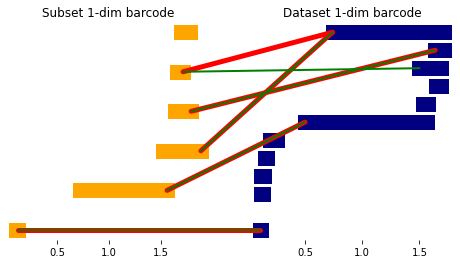

In [16]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
S_barcode = IBloFunMatch_output[0]["S_barcode"]
X_barcode = IBloFunMatch_output[0]["X_barcode"]
max_val = max(np.max(S_barcode),np.max(X_barcode))
for idx, bar in enumerate(S_barcode):
    # ax[0].add_line(mpl.lines.Line2D([bar[0], bar[1]], [idx, idx], c="orange", lw=10))
    ax[0].plot([bar[0], bar[1]], [idx, idx], c="orange", linewidth=15)

for idx, bar in enumerate(X_barcode):
    #ax[1].add_line(mpl.lines.Line2D([bar[0], bar[1]], [idx, idx], c="navy", lw=10))
    ax[1].plot([bar[0], bar[1]], [idx, idx], c="navy", linewidth=15)
    
ax[0].set_title("Subset 1-dim barcode")
ax[1].set_title("Dataset 1-dim barcode")
# Read out (this works in this example but might fail in others)
block_function = []
for col in IBloFunMatch_output[0]["pm_matrix"]:
    if len(col)==0:
        block_function.append(-1)
    else:
        block_function.append(col[-1])
    # end if else 
# end for 

# Plot Block Function
for idx, idx_match in enumerate(block_function):
    pt_S = [S_barcode[idx][1], idx]
    if idx_match==-1:
        continue
    pt_X = [X_barcode[idx_match][0], idx_match]
    con = mpl.patches.ConnectionPatch(
        xyA=pt_S, coordsA=ax[0].transData, 
        xyB=pt_X, coordsB=ax[1].transData,
        arrowstyle="-", connectionstyle='arc',
        color="red", linewidth=5, zorder=1
    )
    fig.add_artist(con)
# end for

# Plot Partial Matching
for idx, idx_match in enumerate(IBloFunMatch_output[0]['induced_matching']):
    pt_S = [S_barcode[idx][1], idx]
    if idx_match==-1:
        continue
    pt_X = [X_barcode[idx_match][0], idx_match]
    con = mpl.patches.ConnectionPatch(
        xyA=pt_S, coordsA=ax[0].transData, 
        xyB=pt_X, coordsB=ax[1].transData,
        arrowstyle="-", connectionstyle='arc',
        color="green", linewidth=2, zorder=1.5
    )
    fig.add_artist(con)
# end for
### Set up plotting options 
for ax_it in ax:
    ax_it.set_frame_on(False)
    ax_it.set_yticks([])
# end for 
plt.savefig("plots/TDQ/IBloFunMatch_S0_ex2.png")

In [17]:
IBloFunMatch_output[0]["pm_matrix"]

[[0], [6], [11], [10], [9, 10, 11], []]

In [18]:
IBloFunMatch_output[0]["S_barcode"]

array([[0.104161, 0.116924],
       [0.71817 , 1.56276 ],
       [1.51872 , 1.89042 ],
       [1.63747 , 1.79588 ],
       [1.65944 , 1.71795 ],
       [1.69628 , 1.78933 ]])

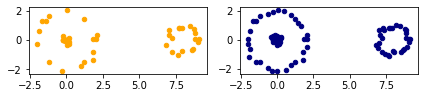

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6,2))
S_pts = IBloFunMatch_output[0]["S"]
X_pts = IBloFunMatch_output[0]["X"]
ax[0].scatter(S_pts[:,0], S_pts[:,1], c="orange", s=20, marker="o")
ax[1].scatter(X_pts[:,0], X_pts[:,1], c="navy", s=20, marker="o")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
fig.tight_layout()
plt.savefig("plots/TDQ/Points_S_X.png")

### Depict simplices of S1 and dataset 

In [20]:
import scipy.spatial.distance as dist

def plot_complex(Dist_X, points, max_rad, ax):
    rips_complex = gudhi.RipsComplex(distance_matrix=Dist_X, max_edge_length=max_rad)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    for filtered_value in simplex_tree.get_filtration():
        spx = filtered_value[0]
        if len(spx)==2:
            edge = points[spx]
            ax.add_line(mpl.lines.Line2D(edge[:,0], edge[:,1], lw=3, color="black", zorder=1))
        elif len(spx)==3:
            triangle = points[spx] 
            ax.add_patch(mpl.patches.Polygon(triangle, facecolor="black", alpha=0.3, zorder=0.5))
        # end if else 
    # end for 
# def plot_complex

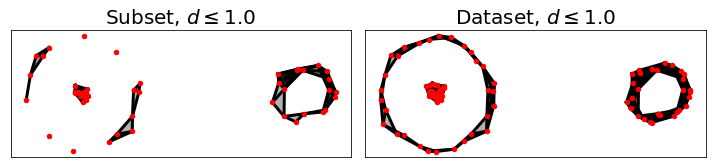

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
max_rad = 1
S = IBloFunMatch_output[0]["S"]
X = IBloFunMatch_output[0]["X"]
point_list = [S, X]
# Compute Distance Matrices
Dist_S = dist.squareform(dist.pdist(S))
Dist_X = dist.squareform(dist.pdist(X))
Dist_list = [Dist_S, Dist_X]
title_list = [f"Subset, $d \leq {max_rad:.1f}$", f"Dataset, $d \leq {max_rad:.1f}$"]
for idx, (X, Dist_X) in enumerate(zip(point_list, Dist_list)):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color="red", s=20)
    plot_complex(Dist_X, X, max_rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=20)
# end for 
fig.tight_layout()
plt.savefig("plots/TDQ/VR_S_X.png")

### Depict Vietoris-Rips complex

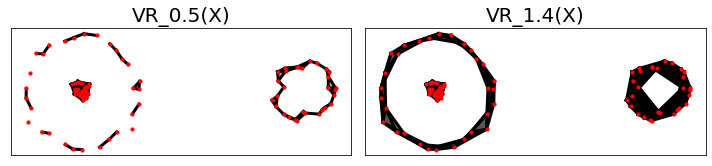

In [22]:
X = IBloFunMatch_output[0]["X"]
Dist_X = dist.squareform(dist.pdist(X))
# Compute Distance Matrices
rad_list = [0.5, 1.4]
title_list = [f"VR_{rad:.1f}(X)" for rad in rad_list]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
for idx, rad in enumerate(rad_list):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color="red", s=10)
    plot_complex(Dist_X, X, rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=20)
# end for 
fig.tight_layout()
plt.savefig("plots/TDQ/VR_grow_data.png")

### Depict Function

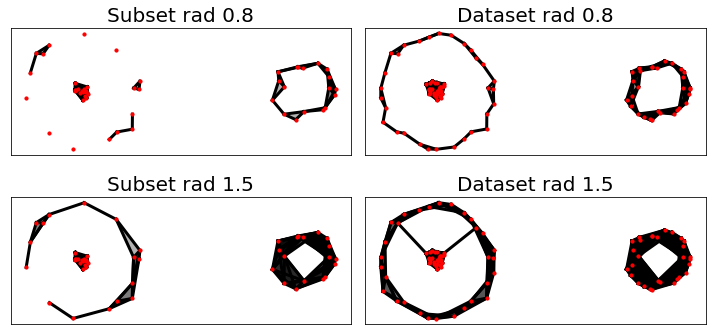

In [23]:
S = IBloFunMatch_output[0]["S"]
X = IBloFunMatch_output[0]["X"]
# Compute Distance Matrices
rad_list = [0.8, 1.5]
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5))
for col, set in enumerate([S, X]):
    Dist = dist.squareform(dist.pdist(set))
    for row, rad in enumerate(rad_list):
        ax[row, col].scatter(set[:,0], set[:,1], zorder=2, color="red", s=10)
        plot_complex(Dist, set, rad, ax[row, col])
        ax[row, col].set_aspect("equal")
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        if col==0:
            ax[row, col].set_title(f"Subset rad {rad:.1f}", fontsize=20)
        else:
            ax[row, col].set_title(f"Dataset rad {rad:.1f}", fontsize=20)
    # for over radii
# end for over sets
fig.tight_layout()
plt.savefig("plots/TDQ/S_X_commute_rad.png")

### Depict 1-Cycles of dataset and barcode (together with induced matrices from subsets)

In [24]:
MIN_BARS = 0.2
X = IBloFunMatch_output[0]["X"]
# Get X barcode and reps for plotting
X_barcode = IBloFunMatch_output[0]["X_barcode"]
X_reps = IBloFunMatch_output[0]["X_reps"]
X_indices = np.nonzero((X_barcode[:,1]-X_barcode[:,0]) > MIN_BARS)[0]
X_barcode = X_barcode[X_indices]
X_reps = [X_reps[idx] for idx in X_indices]

In [25]:
IBloFunMatch_output[0].keys()

dict_keys(['S', 'X', 'idS', 'X_barcode', 'S_barcode', 'X_reps', 'S_reps', 'S_reps_im', 'pm_matrix', 'induced_matching', 'matching_strengths'])

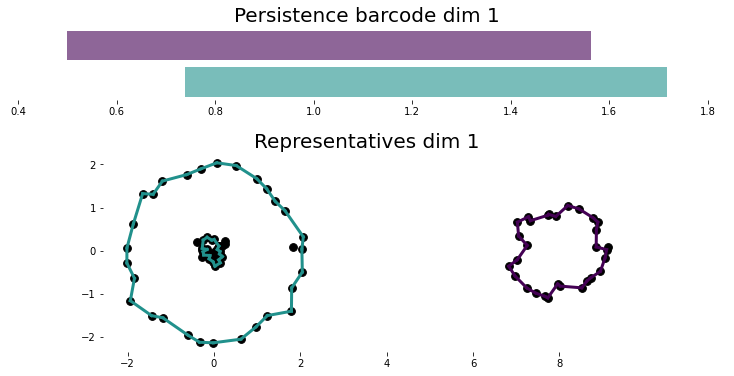

In [26]:
# Plot Barcode and representatives 
num_bars = len(X_barcode)
# viridis_cm = mpl.colormaps["viridis"].resampled(num_bars)
viridis_cm = mpl.colormaps["viridis"]
colorlist = [viridis_cm(idx/num_bars) for idx in range(num_bars)]
# Plot barcode 
fig = plt.figure(figsize=(10, 5))
# Plot barcode 
ax = fig.add_axes((0,0.7, 1, 0.2))
persistence = [(idx, list(bar)) for idx, bar in enumerate(X_barcode)]
gudhi.plot_persistence_barcode(persistence, colormap=colorlist, axes=ax)
ax.get_legend().set_visible(False)
ax.set_frame_on(False)
ax.set_title("Persistence barcode dim 1", fontsize=20)
# Plot Cycle representatives
ax = fig.add_axes((0,0, 1, 0.55))
ax.scatter(X[:,0], X[:,1], zorder=1, color="black", s=60)
ax.set_aspect("equal")
ax.set_title("Representatives dim 1", fontsize=20)
for rep, color in zip(X_reps, colorlist):
    rep = rep.copy()
    while len(rep)>0:
        edge = X[[rep.pop(), rep.pop()]]
        new_line = mpl.lines.Line2D(edge[:,0], edge[:,1], lw=3, color=color, zorder=2)
        ax.add_line(new_line)
    # end while 
# end for 
ax.set_frame_on(False)
plt.savefig("plots/TDQ/PH_reps_data_2.png")

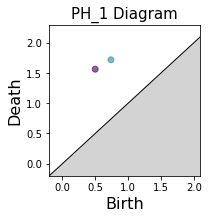

In [27]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes((0.2,0.2,0.7,0.7))
persistence_ext = persistence + [(2,(0,2))]
colorlist_ext = colorlist + ["white"]
gudhi.plot_persistence_diagram(persistence_ext, colormap=colorlist_ext, axes=ax)
ax.get_legend().set_visible(False)
ax.set_title("PH_1 Diagram", fontsize=15)
plt.savefig("plots/TDQ/PH_diag_data_2.png")

### Third Experiment (exp 2 with more points)

In [28]:
# Load data and labels
data = np.genfromtxt("data_third/dataset2.txt")
y = np.genfromtxt("data_third/labels2.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_third/exp2_subset1.txt")
S2 = np.genfromtxt("data_third/exp2_subset2.txt")
# Load their labels 
yS1 = np.genfromtxt("data_third/exp2_labels_subset1.txt")
yS2 = np.genfromtxt("data_third/exp2_labels_subset2.txt")

In [29]:
%%capture
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 2
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2]
yS_list = [yS1, yS2]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset)

sample_indices (100): 14, 21, 123, 366, 81, 52, 367, 328, 182, 142, 0, 91, 70, 31, 349, 183, 209, 77, 166, 229, 41, 268, 72, 135, 141, 27, 399, 330, 344, 133, 15, 350, 66, 2, 291, 389, 69, 386, 124, 270, 197, 82, 140, 106, 262, 379, 148, 175, 177, 240, 311, 118, 384, 329, 104, 137, 309, 219, 283, 335, 150, 388, 53, 49, 149, 54, 345, 220, 6, 94, 378, 372, 194, 238, 244, 261, 265, 111, 22, 152, 285, 223, 125, 40, 192, 297, 334, 287, 62, 160, 190, 217, 321, 201, 353, 247, 341, 348, 178, 203, 
sorted sample indices
Correctly checked inequality on dist_S and dist_X
Sample indices (sorted)
0, 2, 6, 14, 15, 21, 22, 27, 31, 40, 41, 49, 52, 53, 54, 62, 66, 69, 70, 72, 77, 81, 82, 91, 94, 104, 106, 111, 118, 123, 124, 125, 133, 135, 137, 140, 141, 142, 148, 149, 150, 152, 160, 166, 175, 177, 178, 182, 183, 190, 192, 194, 197, 201, 203, 209, 217, 219, 220, 223, 229, 238, 240, 244, 247, 261, 262, 265, 268, 270, 283, 285, 287, 291, 297, 309, 311, 321, 328, 329, 330, 334, 335, 341, 344, 345, 348, 34

In [30]:
%%capture
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("plots/TDQ/third_example_matchings.png")

In [31]:
%%capture
# Plot Point Clouds to visualize matchings
# Range over classes and subsets 
# Get relevant data
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class][idx_subset]]
        X = curr_output["X"]
        S = curr_output["S"]
        induced_matching = curr_output["induced_matching"]
        matching_strengths = curr_output["matching_strengths"]
        # Count number of nontrivial matchings 
        num_matchings = len([idx for idx in induced_matching if idx>-1])
        X_reps = curr_output["X_reps"]
        X_barcode = curr_output["X_barcode"]
        S_reps = curr_output["S_reps"]
        S_barcode = curr_output["S_barcode"]
        S_reps_im = curr_output["S_reps_im"]
        # Plot point clouds and matched representatives
        fig, ax = plt.subplots(nrows=num_matchings, ncols=4, figsize=(24, 5*num_matchings))
        #Plot cycle representatives of matching
        row_count = 0
        for idx_rep, idx_match in enumerate(induced_matching):
            if idx_match <0:
                continue
            # Set axis titles as intervals 
            # ax[row_count, 0].set_title(f"{S_barcode[idx_rep]}", fontsize=25)
            # ax[row_count, 1].set_title(f"strength: {matching_strengths[idx_rep]:.2f}", fontsize=25)
            # ax[row_count, 2].set_title(f"{X_barcode[idx_match]}", fontsize=25)
            # Colored square with strength quantity printed
            ax[row_count, 3].text(0.2, 0.35, f"{matching_strengths[idx_rep]:.2f}", fontsize=100, zorder=1)
            ax[row_count, 3].set_facecolor(class_cm[idx_class](matching_strengths[idx_rep]/X_barcode[idx_match][1]))
            Srep = S_reps[idx_rep].copy()
            while len(Srep)>0:
                edge_points = X[[Srep.pop(), Srep.pop()]]
                ax[row_count, 0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Srep_im = S_reps_im[idx_rep].copy()
            while len(Srep_im)>0:
                edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
                ax[row_count, 1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Xrep = X_reps[idx_match].copy()
            while len(Xrep)>0:
                edge_points = X[[Xrep.pop(), Xrep.pop()]]
                ax[row_count, 2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            # Scatter Points
            for idx, ax_it in enumerate(ax[row_count]):
                if (idx>0) and (idx < 3):
                    ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=10)
                if idx < 3:
                    ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=30)
                ax_it.set_xticks([])
                ax_it.set_yticks([])
            # end plotting cycles
            row_count+=1
        # end going over different matchings 
        fig.tight_layout()
        plt.savefig(f"plots/TDQ/third_reps_{idx_class}_{idx_subset}.png")
    # subset range 
# class range

## Plot Subsets 

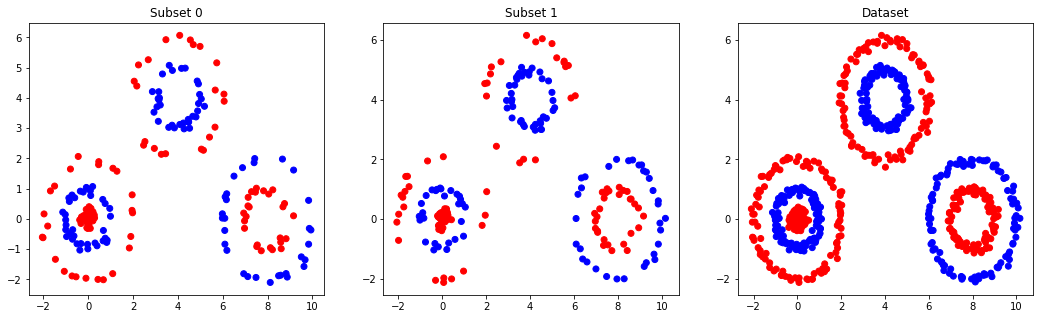

In [32]:
colors=["red", "blue"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
# First subset
S1 = S_list[0]
yS1 = yS_list[0]
for idx, (S, yS) in enumerate(zip(S_list, yS_list)):
    yS = yS.astype("int")
    colorlist = [colors[label] for label in yS]
    ax[idx].scatter(S[:,0], S[:,1], color=colorlist)
    ax[idx].set_title(f"Subset {idx}")

# Total point cloud
y = y.astype("int")
colorlist = [colors[label] for label in y]
ax[2].scatter(data[:,0], data[:,1], color=colorlist)
ax[2].set_title("Dataset")
plt.savefig("plots/TDQ/third_points_and_samples.png")

In [33]:
IBloFunMatch_output[0].keys()

dict_keys(['S', 'X', 'idS', 'X_barcode', 'S_barcode', 'X_reps', 'S_reps', 'S_reps_im', 'pm_matrix', 'induced_matching', 'matching_strengths'])

In [34]:
IBloFunMatch_output[0]["pm_matrix"]

[[], [16], [], [], [31], [36], [33, 34], [], [], [37]]

In [35]:
IBloFunMatch_output[0]["S_barcode"]


array([[0.102223, 0.129831],
       [0.144788, 0.166228],
       [0.156205, 0.226389],
       [0.216619, 0.242031],
       [0.826763, 1.62169 ],
       [1.12716 , 1.82793 ],
       [1.45272 , 1.60939 ],
       [1.64818 , 1.74796 ],
       [1.6912  , 1.74321 ],
       [1.87205 , 3.20184 ]])